In [1]:
import numpy as np
import numpy.random as npr
import csv
import datetime
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from foodbornenyc.models import models as m, documents as d, businesses as b, locations as l
db = m.getDBSession()

In [3]:
%%time
bigreviews = db.query(d.YelpReview).limit(50000).all()

CPU times: user 1.62 s, sys: 232 ms, total: 1.85 s
Wall time: 1.92 s


In [4]:
sample = [rev.text for rev in np.random.choice(bigreviews, 10000, replace=False)]

In [6]:
# pull in rows and sort them by date
rows = []
with open('data/reviews_foodborne_date_biz.csv') as f:
    for i, row in enumerate(csv.reader(f)):
        if i == 0 : continue
        row[1] = int(float(row[1]))
        row[2] = datetime.datetime.strptime(row[2], '%Y-%m-%d')
        rows.append(row)

# sort by date
rows = sorted(rows, key=lambda x:x[2], reverse=True)
            
# grab first 1000 by date
data = {'X':[], 'y':[]}
for i, row in enumerate(rows):
        data['X'].append(unicode(row[0], 'utf8'))
        data['y'].append(row[1])
        if i == 2999:
            break
data['y'] = np.array(data['y'])

# grab sceond 1000 by date
testdata = {'X':[], 'y':[]}
for i, row in enumerate(rows[3000:]):
        testdata['X'].append(row[0])
        testdata['y'].append(row[1])
        #if i == 1000:
        #    break
testdata['y'] = np.array(testdata['y'])

In [7]:
data['X'].extend(sample)
data['y'] = np.append(data['y'], np.zeros(len(sample)))
print len(data['X'])
print data['y'].shape

13000
(13000,)


In [8]:
from sklearn import cross_validation
from sklearn.metrics import roc_curve, auc
folds = cross_validation.StratifiedKFold(data['y'], n_folds=3, random_state=0, shuffle=True)

In [10]:
from sklearn import metrics

def my_roc_auc(ground_truth, predictions):
    ground_truth = np.array(ground_truth)
    predictions = np.array(predictions)
    return metrics.roc_auc_score(ground_truth, predictions, average='micro')

my_roc_auc_scorer = metrics.make_scorer(my_roc_auc, needs_threshold=True, greater_is_better=True)

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
# define baseline pipelines
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer



# Feature Extractors
cv = CountVectorizer(
        input=u'content', 
        encoding=u'utf-8', 
        decode_error=u'strict', 
        strip_accents='unicode', 
        lowercase=True,
        analyzer=u'word', 
        preprocessor=None, 
        tokenizer=None, 
        stop_words='english', 
        #token_pattern=u'(?u)\\b\w\w+\b', # one alphanumeric is a token
        ngram_range=(1, 2), 
        max_df=.9, 
        min_df=2, 
        max_features=None, 
        vocabulary=None, 
        binary=False, 
        #dtype=type 'numpy.int64'>
        )
from sklearn.feature_extraction.text import TfidfTransformer
tf = TfidfTransformer(
        norm='l2',
        use_idf=True,
        smooth_idf=True,
        sublinear_tf=False
)

# Final Classifier
from sklearn.naive_bayes import MultinomialNB
lr = LogisticRegression(C=.05,
                        fit_intercept=True,
                        random_state=0,
                        class_weight='balanced',
                        n_jobs=-1)

pipeline = Pipeline([
    ('count', cv),
    ('tfidf', tf),
    ('logreg', lr)
    ])

param_grid = {
    'count__ngram_range':[(1,1),(1,2),(1,3)],
    'tfidf__norm':['l1', 'l2'],
    'tfidf__use_idf':[True, False],
    'tfidf__sublinear_tf':[True,False],
    'logreg__C':[.001, .01, .1]
}

In [15]:
from sklearn.grid_search import GridSearchCV
grid_search = GridSearchCV(pipeline, 
                           param_grid,
                           cv = folds,
                           scoring=my_roc_auc_scorer,
                           n_jobs=-1, verbose=1)

In [16]:
grid_search.fit(np.array(data['X']), data['y'])
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:  6.5min finished


()
Best score: 0.975
Best parameters set:
	count__ngram_range: (1, 2)
	logreg__C: 0.1
	tfidf__norm: 'l2'
	tfidf__sublinear_tf: True
	tfidf__use_idf: True


(array([  2.,   4.,   6.,   7.,   3.,   3.,   3.,   7.,  19.,  18.]),
 array([ 0.91587056,  0.9218031 ,  0.92773563,  0.93366817,  0.9396007 ,
         0.94553324,  0.95146577,  0.95739831,  0.96333084,  0.96926338,
         0.97519592]),
 <a list of 10 Patch objects>)

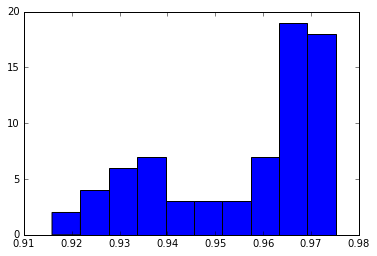

In [17]:
scores = [s.mean_validation_score for s in grid_search.grid_scores_]
plt.hist(scores)

In [18]:
# output the best one
from sklearn.externals import joblib
from foodbornenyc.settings import yelp_classifier_config as config
joblib.dump(grid_search.best_estimator_, '../'+config['model_file']) 

['../foodbornenyc/pipelines/models/yelp_sick_logreg.pkl',
 '../foodbornenyc/pipelines/models/yelp_sick_logreg.pkl_01.npy',
 '../foodbornenyc/pipelines/models/yelp_sick_logreg.pkl_02.npy',
 '../foodbornenyc/pipelines/models/yelp_sick_logreg.pkl_03.npy',
 '../foodbornenyc/pipelines/models/yelp_sick_logreg.pkl_04.npy',
 '../foodbornenyc/pipelines/models/yelp_sick_logreg.pkl_05.npy',
 '../foodbornenyc/pipelines/models/yelp_sick_logreg.pkl_06.npy']